In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

In [32]:
df = pd.read_csv("winequality-red.csv", delimiter=';')   # or white wine dataset

In [33]:
df['quality_label'] = (df['quality'] >= 7).astype(int)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  quality_label  
0      9.4        5              0  
1      9.8  

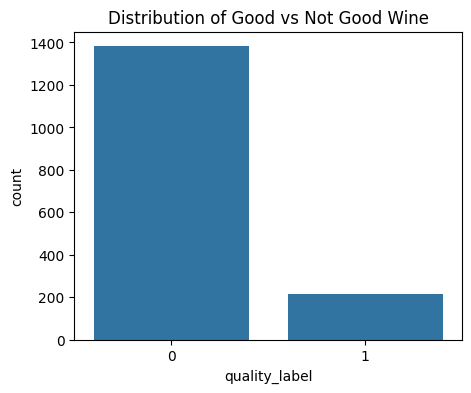

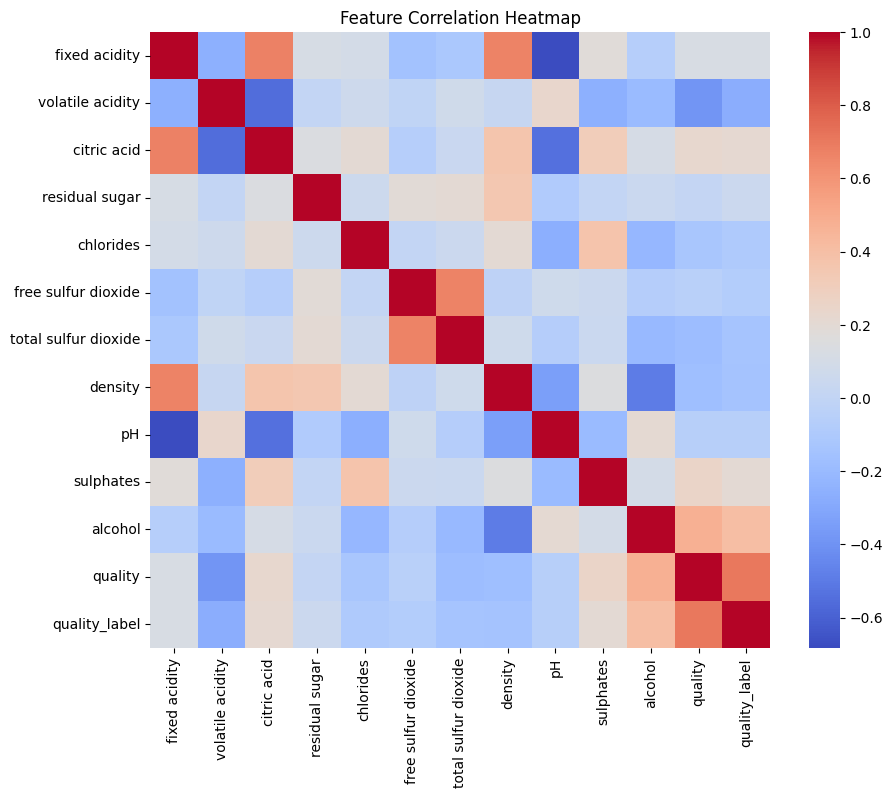

In [34]:
print(df.head())
print("\nClass distribution:\n", df['quality_label'].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x='quality_label', data=df)
plt.title("Distribution of Good vs Not Good Wine")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [35]:
X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=2000))
])

In [36]:
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']  # both support l1
}

grid = GridSearchCV(
    pipeline, param_grid=param_grid, cv=5,
    scoring='f1', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Params: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}



Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       277
           1       0.41      0.79      0.54        43

    accuracy                           0.82       320
   macro avg       0.69      0.81      0.72       320
weighted avg       0.89      0.82      0.84       320


Confusion Matrix:
 [[229  48]
 [  9  34]]

ROC-AUC: 0.900763999664176


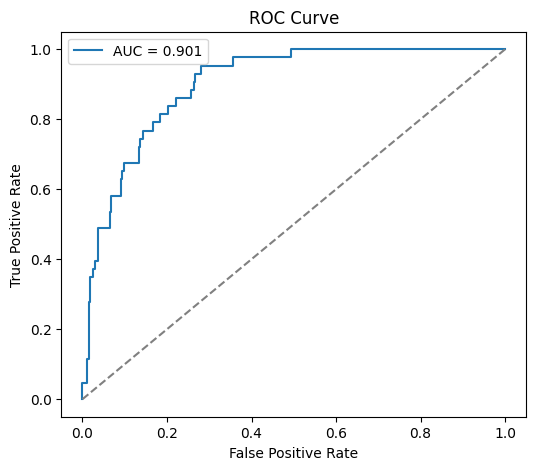

In [37]:
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

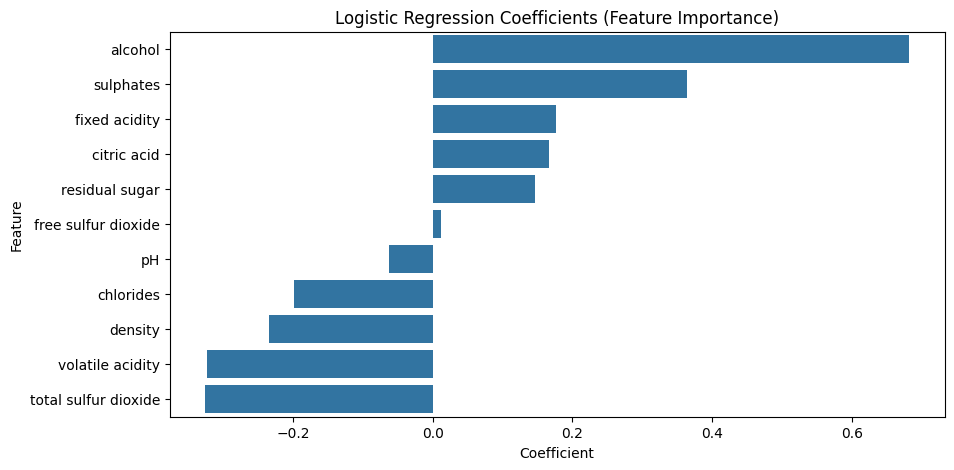

In [38]:
# ==============================
# 10. Feature importance (coefficients)
# ==============================
best_model = grid.best_estimator_.named_steps['logreg']
coeffs = best_model.coef_[0]
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coeffs
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title("Logistic Regression Coefficients (Feature Importance)")
plt.show()
